$ES=F: possibly delisted; no price data found  (1m 2025-07-01 00:00:00 -> 2025-07-02 00:00:00) (Yahoo error = "1m data not available for startTime=1751342400 and endTime=1751428800. The requested range must be within the last 30 days.")
$ES=F: possibly delisted; no price data found  (1m 2025-07-02 00:00:00 -> 2025-07-03 00:00:00) (Yahoo error = "1m data not available for startTime=1751428800 and endTime=1751515200. The requested range must be within the last 30 days.")
$ES=F: possibly delisted; no price data found  (1m 2025-07-03 00:00:00 -> 2025-07-04 00:00:00) (Yahoo error = "1m data not available for startTime=1751515200 and endTime=1751601600. The requested range must be within the last 30 days.")
$ES=F: possibly delisted; no price data found  (1m 2025-07-04 00:00:00 -> 2025-07-05 00:00:00) (Yahoo error = "1m data not available for startTime=1751601600 and endTime=1751688000. The requested range must be within the last 30 days.")
$ES=F: possibly delisted; no price data found  (1m 2

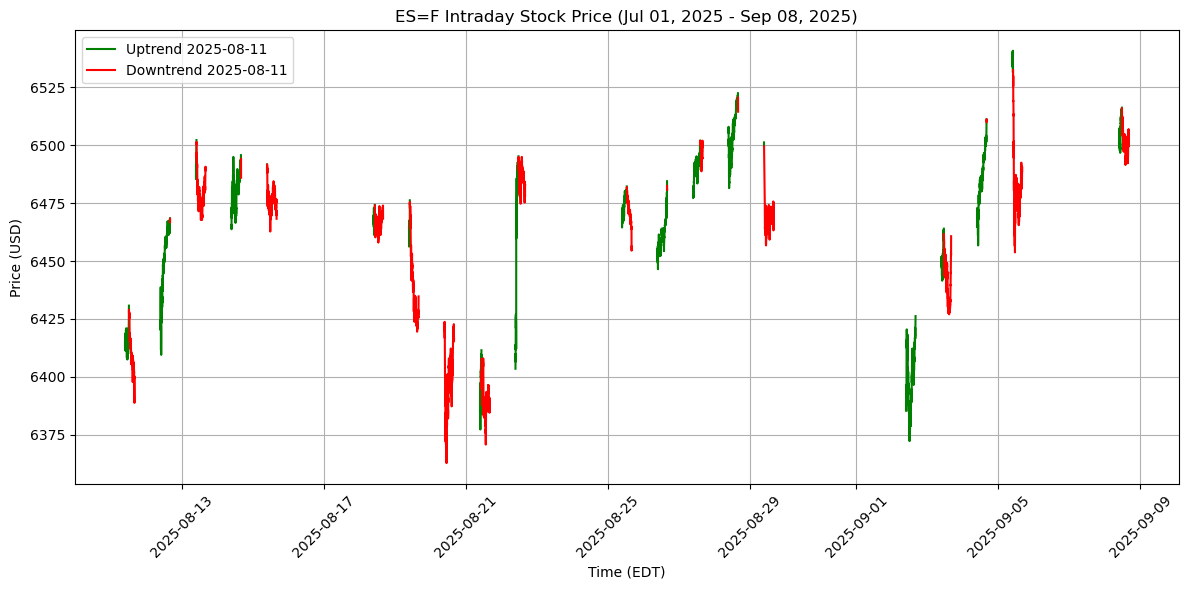

In [4]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time, date

import warnings
warnings.filterwarnings("ignore")

# Function to detect reversal time and prepare data for plotting
def analyze_intraday_trend(ticker, date):
    # Fetch intraday data for the specific date
    stock = yf.Ticker(ticker)
    intraday_data = stock.history(start=date, end=date + pd.Timedelta(days=1), interval="1m")
    
    # Check if data is available
    if intraday_data.empty:
        # print(f"No intraday data available for {ticker} on {date.strftime('%Y-%m-%d')}.")
        return None, None, None, None
    
    # Convert index to timezone-naive for time filtering (assuming EDT)
    intraday_data.index = intraday_data.index.tz_convert('America/New_York').tz_localize(None)
    
    # Filter for regular trading hours (9:30 AM - 4:00 PM EDT)
    intraday_data = intraday_data[(intraday_data.index.time >= time(9, 30)) & (intraday_data.index.time <= time(16, 0))]
    
    # Check again if data is available after filtering
    if intraday_data.empty:
        # print(f"No data within trading hours for {ticker} on {date.strftime('%Y-%m-%d')}.")
        return None, None, None, None
    
    # Find the peak (maximum closing price) to determine reversal point
    peak_time = intraday_data['Close'].idxmax()
    peak_price = intraday_data['Close'].max()
    
    # Split data into uptrend and downtrend
    uptrend_data = intraday_data[intraday_data.index <= peak_time]
    downtrend_data = intraday_data[intraday_data.index > peak_time]
    
    return uptrend_data, downtrend_data, peak_time, peak_price

# Analyze multiple days and plot on a single chart
def analyze_multiple_days(ticker, start_date, end_date):
    all_uptrend_data = []
    all_downtrend_data = []
    reversal_data = []
    
    current_date = start_date
    while current_date.date() <= end_date:
        # print(f"\nAnalyzing {ticker} for {current_date.strftime('%Y-%m-%d')}:")
        uptrend_data, downtrend_data, peak_time, peak_price = analyze_intraday_trend(ticker, current_date)
        if uptrend_data is not None:
            all_uptrend_data.append((current_date.strftime('%Y-%m-%d'), uptrend_data))
            all_downtrend_data.append((current_date.strftime('%Y-%m-%d'), downtrend_data))
            reversal_data.append({
                'Date': current_date.strftime('%Y-%m-%d'),
                'Reversal Time': peak_time.strftime('%I:%M %p EDT'),
                'Peak Price': f"${peak_price:.2f}"
            })
            # print(f"Reversal Time: {peak_time.strftime('%I:%M %p EDT')}, Peak Price: ${peak_price:.2f}")
        current_date += pd.Timedelta(days=1)
    
    # Create DataFrame from reversal data
    if reversal_data:
        df = pd.DataFrame(reversal_data)
        # print("\nReversal Times DataFrame:")
        # print(df)
        
        # Calculate average reversal time
        avg_time = pd.to_datetime(df['Reversal Time'], format='%I:%M %p EDT').mean().time()
        # print(f"\nAverage Reversal Time: {avg_time.strftime('%I:%M %p EDT')}")
    else:
        # print("\nNo valid reversal times to create a DataFrame.")
        return
    
    # Plot all days on a single chart
    plt.figure(figsize=(12, 6))
    for date, uptrend in all_uptrend_data:
        plt.plot(uptrend.index, uptrend['Close'], label=f'Uptrend {date}' if date == all_uptrend_data[0][0] else "", color='green')
    for date, downtrend in all_downtrend_data:
        plt.plot(downtrend.index, downtrend['Close'], label=f'Downtrend {date}' if date == all_downtrend_data[0][0] else "", color='red')
    
    plt.title(f"{ticker} Intraday Stock Price ({start_date.strftime('%b %d, %Y')} - {end_date.strftime('%b %d, %Y')})")
    plt.xlabel("Time (EDT)")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Define start and end dates
start_date = datetime(2025, 7, 1)
end_date = date.today()

# Run analysis for ES=F
analyze_multiple_days("ES=F", start_date, end_date)